In [14]:
import sys
# append the path of the parent directory
# sys.path.append("..")
sys.path[0] += "/../.."

from src.files.utils.utility_functions import *
import sys
import torch.nn as nn
from src.files.utils.dataset_creator import *
from src.files.classes.neural_models import *
# from src.files.neural_ransac import RModel, NeuralRansac
from sklearn.datasets import make_blobs, make_circles

In [15]:
def get_distance(x1, x2):
    if isinstance(x1, torch.Tensor): x1 = x1.detach().numpy()
    if isinstance(x2, torch.Tensor): x2 = x2.detach().numpy()
    return np.sqrt(np.sum((x1-x2)**2))


class RBF:

    def __init__(self, x, k, gamma=1):
        self.X = x
        self.K = k
        self.gammas = [np.random.uniform() for _ in range(self.K)]

        self.weights = None
        self.centers = None

    def kernel(self, point, center, i):
        return np.exp(-self.gammas[i] * np.linalg.norm(point-center)**2)    
    
    def find_centers(self, max_iters):
        # centroids = self.X[np.random.choice(range(len(self.X)), self.K, replace=False)]
        centroids = np.random.uniform(-2, 2, (self.K, self.X.shape[1]))
        converged = False
        curr_it = 0
        
        while (not converged) and (curr_it < max_iters):
            cluster_list = [[] for i, _ in enumerate(centroids)]

            for x in self.X:
                distances = [get_distance(c, x) for c in centroids]
                cluster_list[int(np.argmin(distances))].append(x)

            cluster_list = list(filter(None, cluster_list))
            prev_centroids = centroids.copy()

            centroids = [np.mean(cluster_list[j], axis=0) for j, _ in enumerate(cluster_list)]
            pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

            # print("K-means: ", int(pattern))
            converged = (pattern == 0)

            curr_it += 1
        self.centers = np.array(centroids)
        print(f"# centers: {len(self.centers)}")
        return np.array(centroids), [np.std(x) for x in cluster_list]

    def find_weights(self):
        centers = self.find_centers(1000000)[0] if self.centers is None else self.centers
        phi = np.array([[self.kernel(point, center, i) for i, center in enumerate(centers)] for point in self.X])
        denom = np.linalg.inv((phi.T @ phi))
        w = denom @ phi.T @ self.X
        self.weights = w
        return w
    
    def predict(self):
        weights = self.find_weights() if self.weights is None else self.weights

        res = np.zeros(self.X.shape)
        for i, point in enumerate(self.X):
            for j, center in enumerate(self.centers):
                res[i] += weights[j] * self.kernel(point, center, j)
        return res

In [23]:
import copy


def find_centers(X, K, max_iters=1000):
    # centroids = self.X[np.random.choice(range(len(self.X)), self.K, replace=False)]
    centroids = np.random.uniform(-2, 2, (K, X.shape[1]))
    converged = False
    curr_it = 0
    
    while (not converged) and (curr_it < max_iters):
        cluster_list = [[] for i, _ in enumerate(centroids)]

        for x in X:
            distances = [get_distance(c, x) for c in centroids]
            cluster_list[int(np.argmin(distances))].append(x)

        cluster_list = list(filter(None, cluster_list))
        prev_centroids = centroids.copy()

        centroids = [np.mean(cluster_list[j], axis=0) for j, _ in enumerate(cluster_list)]
        pattern = np.abs(np.sum(prev_centroids) - np.sum(centroids))

        # print("K-means: ", int(pattern))
        converged = (pattern == 0)

        curr_it += 1

    print(f"# centers: {len(centroids)}")
    return np.array(centroids), [np.std(x) for x in cluster_list]

# Hidden's weights (gammas): vector of size Kx1, in which are stored the gammas of the Gaussian functions (learnable parameter)
# Output's weights:          vector of weights dxK, in which are stored the weights of the linear output
# k is the number of clusters, d is the number of dimensions of the input

class GaussianKernel(nn.Module):

    def __init__(self, centers):
        super(GaussianKernel, self).__init__()
        self.centers = torch.FloatTensor(centers)
        self.gammas = nn.Parameter(torch.randn((len(centers),), requires_grad=True))
        self.gammas.requiresGrad = True
        nn.init.normal_(self.gammas.data, std=0.05)

    def forward(self, x):
        #assert x.shape[1] == self.centers.shape[1]
        res = [torch.exp(-self.gammas * torch.linalg.norm(el - self.centers, dim=1)**2) for el in x]
        # print(res)
        return torch.stack(res)

class RBFNetwork(nn.Module):

    def __init__(self, centers, alpha=0.2):
        super(RBFNetwork, self).__init__()
        self.k = len(centers)
        self.centers = centers
        self.alpha = alpha

        self.hidden = GaussianKernel(self.centers)
        self.weights = None
        # self.output = nn.Linear(self.k, 2, bias=False)

    def forward(self, x):
        x = self.hidden(x)
        x2 = x @ self.weights
        # x2 = self.output(x)
        return x2


    def fit(self, X, y, epochs=1, lr=1e-4, bs=8):
        X = torch.FloatTensor(X)
        y = torch.FloatTensor(y)
        # linear_optimizer = torch.optim.SGD(self.output.parameters(), lr)
        gammas_optimizer = torch.optim.Adagrad(self.hidden.parameters(), lr)#, weight_decay=0.5)

        loss_func = torch.nn.MSELoss(reduction="mean")

        loader = Data.DataLoader(
            dataset=Data.TensorDataset(X, y),
            batch_size=bs,
            shuffle=True,
            num_workers=8,
        )

        # self.hidden.train(True)
        # self.output.train(True)

        # each epoch is run twice: 1 run to optimize W with Gamma fixed,
        # the other run to optimize Gamma with W fixed
        for step in range(epochs):
            sys.stdout.write(f"Epoch {step+1}:\t[")
            
            loss_counter = 0
            # weights_before = copy.deepcopy(self.output)
            gammas_before = copy.deepcopy(self.hidden)

            # compute the weights in closed form
            # alpha * I is needed for Ridge Regression 

            phi = self.hidden(X)
            # print(phi.shape)
            K = phi @ phi.T

            a = torch.linalg.inv((K + self.alpha*torch.eye(K.shape[0]))) @ y
            self.weights = phi.T @ a

            # denom = torch.linalg.inv(self.alpha * torch.eye(phi.shape[1]) + phi.T @ phi)
            # self.weights = denom @ phi.T @ y

            self.weights.requiresGrad = False

            # print(self.weights.shape)
            # self.output.weight = weights

            for i, (b_x, b_y) in enumerate(loader):
                # sys.stdout.write(f"=")
                # sys.stdout.flush()
                # even num of steps --> weights
                #if step % 2 == 0:
                #    # self.hidden.train(False)
                #    # self.output.train(True)
#
                #    linear_optimizer.zero_grad()
#
                #    prediction = self(b_x)
                #    loss = loss_func(prediction, b_y)
#
                #    penalization = self.alpha * torch.norm(self.output.weight)
                #    loss_counter += loss.item() + penalization
                #    loss.backward()
#
                #    weights_before = copy.deepcopy(self.output)
                #    linear_optimizer.step()
                #    # print("DIFFERENCE (weights): ", weights_before.weight - self.output.weight)
                #else:
                    # self.hidden.train(True)
                    # self.output.train(False)

                gammas_optimizer.zero_grad()

                prediction = self(b_x)
                loss = loss_func(prediction, b_y)

                penalization = self.alpha * torch.norm(self.hidden.gammas)
                loss_counter += loss.item()# + penalization
                loss.backward(retain_graph=True)
                
                # gammas_before = copy.deepcopy(self.hidden)
                gammas_optimizer.step()
                # print("DIFFERENCE (gammas): ", gammas_before.gammas - self.hidden.gammas)
            # sys.stdout.write("]")
            # sys.stdout.write(f"\t({i}/{len(X) // bs})\t")
            # sys.stdout.write(f"MeanLoss: {(loss_counter / len(X)):.6f}\n")

            # if step % 10 == 0:
            #     print("\nStep #", step)
            #     if step % 2 == 0: print("Updating weights") 
            #     else: print("Updating gammas")
            #     print("Loss counter: ", loss_counter)
            #     print("Loss: ", loss)
            #     print("Weights: ", weights_before.weight - self.output.weight)
            #     print("Gammas: ", gammas_before.gammas - self.hidden.gammas)
            #     print()

In [24]:
torch.autograd.set_detect_anomaly(True)

#ds, lbs, centroids = make_blobs(n_samples=300, return_centers=True)
ds, gt = create_dataset_parabola(200, a_s=[1], centers=[(2, 2)], rot_angle=[90], outliers_fraction=0.5)
#ds = create_dataset_circle(300, fraction=0.4)
# ds = create_square(num_points=300)
ds = normalize_points(ds)

centers = find_centers(X=ds, K=1)[0]
rbf = RBFNetwork(centers)

ds = torch.FloatTensor(ds)

rbf.fit(X=ds, y=ds, epochs=100, lr=1e-2)

# centers: 1
Epoch 1:	[Epoch 2:	[Epoch 3:	[Epoch 4:	[Epoch 5:	[Epoch 6:	[Epoch 7:	[Epoch 8:	[Epoch 9:	[Epoch 10:	[Epoch 11:	[Epoch 12:	[Epoch 13:	[Epoch 14:	[Epoch 15:	[Epoch 16:	[Epoch 17:	[Epoch 18:	[Epoch 19:	[Epoch 20:	[Epoch 21:	[Epoch 22:	[Epoch 23:	[Epoch 24:	[Epoch 25:	[Epoch 26:	[Epoch 27:	[Epoch 28:	[Epoch 29:	[Epoch 30:	[Epoch 31:	[Epoch 32:	[Epoch 33:	[Epoch 34:	[Epoch 35:	[Epoch 36:	[Epoch 37:	[Epoch 38:	[Epoch 39:	[Epoch 40:	[Epoch 41:	[Epoch 42:	[Epoch 43:	[Epoch 44:	[Epoch 45:	[Epoch 46:	[Epoch 47:	[Epoch 48:	[Epoch 49:	[Epoch 50:	[Epoch 51:	[Epoch 52:	[Epoch 53:	[Epoch 54:	[Epoch 55:	[Epoch 56:	[Epoch 57:	[Epoch 58:	[Epoch 59:	[Epoch 60:	[Epoch 61:	[Epoch 62:	[Epoch 63:	[Epoch 64:	[Epoch 65:	[Epoch 66:	[Epoch 67:	[Epoch 68:	[Epoch 69:	[Epoch 70:	[Epoch 71:	[Epoch 72:	[Epoch 73:	[Epoch 74:	[Epoch 75:	[Epoch 76:	[Epoch 77:	[Epoch 78:	[Epoch 79:	[Epoch 80:	[Epoch 81:	[Epoch 82:	[Epoch 83:	[Epoch 84:	[Epoch 85:	[Epoch 86:	[Epoch 87:	[Epoch 88:	[Epoch 89:	[Epoch 90:	[Epoch 

#ds, lbs, centroids = make_blobs(n_samples=300, return_centers=True)
#ds = create_dataset_parabola(200, 1, 0, 0, outliers=100)
ds = create_dataset_circle(300, inlier_fraction=0.4)
# ds = create_square(n_points=300)
ds = normalize_points(ds)

epsilon = 0.5
samples = ds[np.random.randint(len(ds), size=(10,))]

centers = find_centers(X=samples, K=10)[0]
rbf = RBFNetwork(alpha=0.5, centers=centers)

rbf.fit(samples, samples, epochs=20)

consensus = []
for el in ds:
    error = get_distance(rbf(el), el)
    if error**2 < epsilon**2:
        consensus.append(torch.FloatTensor(el))

consensus = torch.stack(consensus)

print(f"Consensus: {consensus.shape}")

rbf.fit(consensus, consensus, epochs=20)

(200, 2)


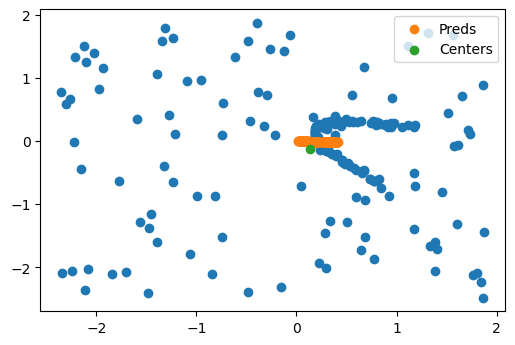

In [25]:
preds = rbf(torch.FloatTensor(ds)).detach().numpy()

# preds = torch.FloatTensor(list(filter(lambda x: -5 <= x[0] <= 5 and -5 <= x[1] <= 5, preds)))

points = torch.FloatTensor(10, 2).uniform_(-5, 5)
points_preds = rbf(points).detach().numpy()
points = points.detach().numpy()

print(preds.shape)

fig = plt.figure(dpi=100)
plt.scatter(ds[:,0], ds[:,1])
plt.scatter(preds[:,0], preds[:,1], label="Preds")
plt.scatter(centers[:,0], centers[:,1], label="Centers")
# plt.scatter(points[:,0], points[:,1], label="Points")
# plt.scatter(points_preds[:,0], points_preds[:,1], label="PPreds")
plt.legend()

In [19]:
rbf.hidden.gammas

Parameter containing:
tensor([0.2035], requires_grad=True)

In [20]:
rbf.weights

tensor([[ 0.2964, -0.0101]], grad_fn=<MmBackward>)

In [21]:
if True:
    model = RModel()
    train_model(iterations=100, data=ds, model=model)
    preds = model(torch.FloatTensor(ds)).detach().numpy()

NameError: name 'RModel' is not defined

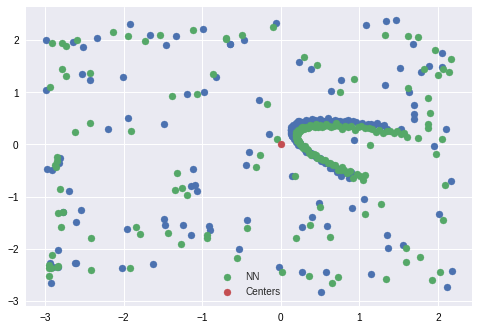

In [ ]:
plt.scatter(ds[:,0], ds[:,1])
# plt.scatter(res[:,0], res[:,1], label="RBF")
plt.scatter(preds[:,0], preds[:,1], label="NN")
plt.scatter(rbf.centers[:,0], rbf.centers[:,1], label="Centers")
plt.legend()